# Simulation with default parameters and periodic boundary conditions on slab mesh

The following notebook outlines a sample simulation of the perfusion and gas exchange model on a periodic mesh mimicking an infinite sheet positioned between alveoli (an approximation to the 2D problem, collapsing the $\boldsymbol{\hat{z}}$ axis). We start without considering hemoglobin effects.

Import necessary packages and add the working directory to the system path.

In [1]:
import sys
import os
import dolfin
import pandas as pd
import matplotlib.pyplot as plt
from ipygany import Scene, PolyMesh, ColorBar, IsoColor
from ipywidgets import Play, IntProgress, link, VBox
plt.style.use('ggplot')
sys.path.append(os.getcwd()[:-6])

Import the model modules.

In [2]:
from src.model import PerfusionGasExchangeModel
from src.params import params

Set a target folder for `vtk` files.

In [3]:
folder = "periodic-bcs-no-hb"
path = os.path.join("../raw-data", folder)

Instance the model and run simulation.

In [4]:
model = PerfusionGasExchangeModel(folder_path=path, params=params)
model.generate_slab_mesh(
    dims=(200, 6, 6), elems=(200, 6, 6), save=True, periodic=True
)
model.sim_p(save=True, meshtype="slab")
model.sim_bst(final_time=1, num_steps=5, save=True, hb=False)
boundaries = dolfin.File(model.folder_path+'/bnd/bnd.pvd')
boundaries << model.boundaries

Solving linear variational problem.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.726e+04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.293e-09 (tol = 1.000e-10) r (rel) = 2.628e-14 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Finished time step 1/5 (20%)

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.705e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.980e-10 (tol = 1.000e-10) r (rel) = 2.334e-11 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Finished time step 2/5 (40%)

No Jacobian form specified for nonlinear varia

Visualize using `iygany`. As an example, we start with $p$. Currently, prior knowledge of the `vtu` file is needed to visualize this. There's probably a better way to do this.

In [5]:
mesh = PolyMesh.from_vtk(os.path.join(model.folder_path, 'p/p000000.vtu'))
iso = IsoColor(mesh, input='f_18', min=8, max=12)
scene = Scene([iso])
bar = ColorBar(iso)
VBox(children=(scene, bar))

Next we visualize $p_{\text{O}_{2}}$.

In [6]:
mesh_dynamic = PolyMesh.from_vtk(
    os.path.join(model.folder_path, 'bst/pO2000000.vtu')
)

def load_step(change):
    mesh_dynamic.reload(
        os.path.join(model.folder_path, 'bst/pO20000{}.vtu').format(
            str(change['new']).zfill(2)
        ), reload_vertices=True
    )

play = Play(description='Step:', min=1, max=15, value=1)
play.observe(load_step, names=['value'])

progress = IntProgress(value=1, step=1, min=1, max=15)
link((progress, 'value'), (play, 'value'))

stepper = VBox((play, progress))
iso = IsoColor(mesh_dynamic, input='f_48-0', min=40, max=100)
bar = ColorBar(iso)
scene = Scene([iso])

VBox(children=(scene, stepper, bar))

Use ParaView to extract data. This requires the pvpython environment or adding ParaView to the Python PATH.

In [7]:
# trace generated using paraview version 5.7.0
#
# To ensure correct image size when batch processing, please search 
# for and uncomment the line `# renderView*.ViewSize = [*,*]`

#### import the simple module from the paraview
from paraview.simple import *
#### disable automatic camera reset on 'Show'
paraview.simple._DisableFirstRenderCameraReset()

# get animation scene
animationScene1 = GetAnimationScene()

# get the time-keeper
timeKeeper1 = GetTimeKeeper()

# create a new 'PVD Reader'
pO2pvd = PVDReader(FileName="""\\\\wsl$\\Ubuntu\\home\\pzuritas\
um-model-alv-perfusion-gas-exchange\\raw-data\\periodic-bcs-no-hb\\bst\\pO2.pvd""")
pO2pvd.PointArrays = ['f_48-0']

# update animation scene based on data timesteps
animationScene1.UpdateAnimationUsingDataTimeSteps()

# get active view
renderView1 = GetActiveViewOrCreate('RenderView')
# uncomment following to set a specific view size
# renderView1.ViewSize = [968, 504]

# show data in view
pO2pvdDisplay = Show(pO2pvd, renderView1)

# get color transfer function/color map for 'f_480'
f_480LUT = GetColorTransferFunction('f_480')
f_480LUT.RGBPoints = [38.419171747562224, 0.231373, 0.298039, 0.752941, 39.20958587378111, 0.865003, 0.865003, 0.865003, 40.0, 0.705882, 0.0156863, 0.14902]
f_480LUT.ScalarRangeInitialized = 1.0

# get opacity transfer function/opacity map for 'f_480'
f_480PWF = GetOpacityTransferFunction('f_480')
f_480PWF.Points = [38.419171747562224, 0.0, 0.5, 0.0, 40.0, 1.0, 0.5, 0.0]
f_480PWF.ScalarRangeInitialized = 1

# trace defaults for the display properties.
pO2pvdDisplay.Representation = 'Surface'
pO2pvdDisplay.ColorArrayName = ['POINTS', 'f_48-0']
pO2pvdDisplay.LookupTable = f_480LUT
pO2pvdDisplay.OSPRayScaleArray = 'f_48-0'
pO2pvdDisplay.OSPRayScaleFunction = 'PiecewiseFunction'
pO2pvdDisplay.SelectOrientationVectors = 'None'
pO2pvdDisplay.ScaleFactor = 20.0
pO2pvdDisplay.SelectScaleArray = 'f_48-0'
pO2pvdDisplay.GlyphType = 'Arrow'
pO2pvdDisplay.GlyphTableIndexArray = 'f_48-0'
pO2pvdDisplay.GaussianRadius = 1.0
pO2pvdDisplay.SetScaleArray = ['POINTS', 'f_48-0']
pO2pvdDisplay.ScaleTransferFunction = 'PiecewiseFunction'
pO2pvdDisplay.OpacityArray = ['POINTS', 'f_48-0']
pO2pvdDisplay.OpacityTransferFunction = 'PiecewiseFunction'
pO2pvdDisplay.DataAxesGrid = 'GridAxesRepresentation'
pO2pvdDisplay.PolarAxes = 'PolarAxesRepresentation'
pO2pvdDisplay.ScalarOpacityFunction = f_480PWF
pO2pvdDisplay.ScalarOpacityUnitDistance = 5.705047443703445
pO2pvdDisplay.InputVectors = [None, '']

# init the 'PiecewiseFunction' selected for 'OSPRayScaleFunction'
pO2pvdDisplay.OSPRayScaleFunction.Points = [-1.4710778371729638, 0.0, 0.5, 0.0, 13.820882932333754, 1.0, 0.5, 0.0]

# init the 'PiecewiseFunction' selected for 'ScaleTransferFunction'
pO2pvdDisplay.ScaleTransferFunction.Points = [38.59429839920696, 0.0, 0.5, 0.0, 40.0, 1.0, 0.5, 0.0]

# init the 'PiecewiseFunction' selected for 'OpacityTransferFunction'
pO2pvdDisplay.OpacityTransferFunction.Points = [38.59429839920696, 0.0, 0.5, 0.0, 40.0, 1.0, 0.5, 0.0]

# reset view to fit data
renderView1.ResetCamera()

# get the material library
materialLibrary1 = GetMaterialLibrary()

# show color bar/color legend
pO2pvdDisplay.SetScalarBarVisibility(renderView1, True)

# update the view to ensure updated data information
renderView1.Update()

# create a new 'Plot Over Line'
plotOverLine1 = PlotOverLine(Input=pO2pvd,
    Source='High Resolution Line Source')

# init the 'High Resolution Line Source' selected for 'Source'
plotOverLine1.Source.Point2 = [200.0, 6.0, 6.0]

# show data in view
plotOverLine1Display = Show(plotOverLine1, renderView1)

# trace defaults for the display properties.
plotOverLine1Display.Representation = 'Surface'
plotOverLine1Display.ColorArrayName = ['POINTS', 'f_48-0']
plotOverLine1Display.LookupTable = f_480LUT
plotOverLine1Display.OSPRayScaleArray = 'f_48-0'
plotOverLine1Display.OSPRayScaleFunction = 'PiecewiseFunction'
plotOverLine1Display.SelectOrientationVectors = 'None'
plotOverLine1Display.ScaleFactor = 20.0
plotOverLine1Display.SelectScaleArray = 'f_48-0'
plotOverLine1Display.GlyphType = 'Arrow'
plotOverLine1Display.GlyphTableIndexArray = 'f_48-0'
plotOverLine1Display.GaussianRadius = 1.0
plotOverLine1Display.SetScaleArray = ['POINTS', 'f_48-0']
plotOverLine1Display.ScaleTransferFunction = 'PiecewiseFunction'
plotOverLine1Display.OpacityArray = ['POINTS', 'f_48-0']
plotOverLine1Display.OpacityTransferFunction = 'PiecewiseFunction'
plotOverLine1Display.DataAxesGrid = 'GridAxesRepresentation'
plotOverLine1Display.PolarAxes = 'PolarAxesRepresentation'
plotOverLine1Display.InputVectors = [None, '']

# init the 'PiecewiseFunction' selected for 'OSPRayScaleFunction'
plotOverLine1Display.OSPRayScaleFunction.Points = [-1.4710778371729638, 0.0, 0.5, 0.0, 13.820882932333754, 1.0, 0.5, 0.0]

# init the 'PiecewiseFunction' selected for 'ScaleTransferFunction'
plotOverLine1Display.ScaleTransferFunction.Points = [38.59448291006616, 0.0, 0.5, 0.0, 40.0, 1.0, 0.5, 0.0]

# init the 'PiecewiseFunction' selected for 'OpacityTransferFunction'
plotOverLine1Display.OpacityTransferFunction.Points = [38.59448291006616, 0.0, 0.5, 0.0, 40.0, 1.0, 0.5, 0.0]

# Create a new 'Line Chart View'
lineChartView1 = CreateView('XYChartView')
# uncomment following to set a specific view size
# lineChartView1.ViewSize = [400, 400]

# show data in view
plotOverLine1Display_1 = Show(plotOverLine1, lineChartView1)

# trace defaults for the display properties.
plotOverLine1Display_1.CompositeDataSetIndex = [0]
plotOverLine1Display_1.UseIndexForXAxis = 0
plotOverLine1Display_1.XArrayName = 'arc_length'
plotOverLine1Display_1.SeriesVisibility = ['f_48-0']
plotOverLine1Display_1.SeriesLabel = ['arc_length', 'arc_length', 'f_48-0', 'f_48-0', 'vtkValidPointMask', 'vtkValidPointMask', 'Points_X', 'Points_X', 'Points_Y', 'Points_Y', 'Points_Z', 'Points_Z', 'Points_Magnitude', 'Points_Magnitude']
plotOverLine1Display_1.SeriesColor = ['arc_length', '0', '0', '0', 'f_48-0', '0.89', '0.1', '0.11', 'vtkValidPointMask', '0.22', '0.49', '0.72', 'Points_X', '0.3', '0.69', '0.29', 'Points_Y', '0.6', '0.31', '0.64', 'Points_Z', '1', '0.5', '0', 'Points_Magnitude', '0.65', '0.34', '0.16']
plotOverLine1Display_1.SeriesPlotCorner = ['arc_length', '0', 'f_48-0', '0', 'vtkValidPointMask', '0', 'Points_X', '0', 'Points_Y', '0', 'Points_Z', '0', 'Points_Magnitude', '0']
plotOverLine1Display_1.SeriesLabelPrefix = ''
plotOverLine1Display_1.SeriesLineStyle = ['arc_length', '1', 'f_48-0', '1', 'vtkValidPointMask', '1', 'Points_X', '1', 'Points_Y', '1', 'Points_Z', '1', 'Points_Magnitude', '1']
plotOverLine1Display_1.SeriesLineThickness = ['arc_length', '2', 'f_48-0', '2', 'vtkValidPointMask', '2', 'Points_X', '2', 'Points_Y', '2', 'Points_Z', '2', 'Points_Magnitude', '2']
plotOverLine1Display_1.SeriesMarkerStyle = ['arc_length', '0', 'f_48-0', '0', 'vtkValidPointMask', '0', 'Points_X', '0', 'Points_Y', '0', 'Points_Z', '0', 'Points_Magnitude', '0']

# get layout
layout1 = GetLayoutByName("Layout #1")

# add view to a layout so it's visible in UI
AssignViewToLayout(view=lineChartView1, layout=layout1, hint=0)

# save data
SaveData('//wsl$/Ubuntu/home/pzuritas/num-model-alv-perfusion-gas-exchange/raw-data/periodic-bcs-no-hb/bst/curve_middle_po2.csv', proxy=plotOverLine1)

# update the view to ensure updated data information
renderView1.Update()

# update the view to ensure updated data information
lineChartView1.Update()

# set active view
SetActiveView(renderView1)

# save data
SaveData('//wsl$/Ubuntu/home/pzuritas/num-model-alv-perfusion-gas-exchange/raw-data/periodic-bcs-no-hb/bst/curve_top_po2.csv', proxy=plotOverLine1)

# update the view to ensure updated data information
renderView1.Update()

# update the view to ensure updated data information
lineChartView1.Update()

# set active view
SetActiveView(lineChartView1)

# save data
SaveData('//wsl$/Ubuntu/home/pzuritas/num-model-alv-perfusion-gas-exchange/raw-data/periodic-bcs-no-hb/bst/curve_quarter_po2.csv', proxy=plotOverLine1)

#### saving camera placements for all active views

# current camera placement for renderView1
renderView1.CameraPosition = [164.71178875203265, -34.876909608322535, -307.6813347598028]
renderView1.CameraFocalPoint = [100.00000000000001, 2.999999999999995, 2.9999999999999627]
renderView1.CameraViewUp = [0.050199956717279906, 0.9926011362790441, -0.11055744481098413]
renderView1.CameraParallelScale = 100.08995953640904

#### uncomment the following to render all views
# RenderAllViews()
# alternatively, if you want to write images, you can use SaveScreenshot(...).

ModuleNotFoundError: No module named 'paraview'

Read data into CSV files. We take the oxygen partial pressure along the capillary at three different heights ($y$).

In [8]:
middle = pd.read_csv(
    '../raw-data/periodic-bcs-no-hb/bst/curve_middle_po2.csv'
)
quarter = pd.read_csv(
    '../raw-data/periodic-bcs-no-hb/bst/curve_quarter_po2.csv'
)
top = pd.read_csv(
    '../raw-data/periodic-bcs-no-hb/bst/curve_top_po2.csv'
)

And we visualize the results

In [ ]:
os.makedirs(os.path.join('../results-data/', folder))

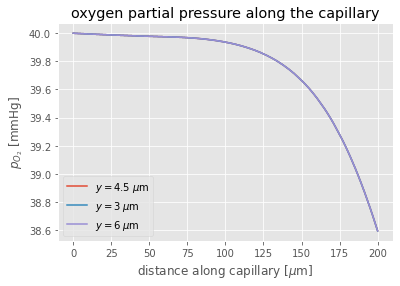

In [12]:
plt.figure()
plt.title('oxygen partial pressure along the capillary')
plt.ylabel(r'$p_{O_2}$ [mmHg]')
plt.xlabel(r'distance along capillary [$\mu$m]')
plt.plot(
    quarter["arc_length"], quarter["f_48-0"], label=r'$y=4.5 \; \mu$m'
)
plt.plot(
    middle["arc_length"], middle["f_48-0"], label=r'$y=3 \; \mu$m'
)
plt.plot(
    top["arc_length"], top["f_48-0"], label=r'$y=6 \; \mu$m'
)
plt.legend()
plt.savefig(os.path.join('../results-data/', folder, 'po2_along_cap.pdf'))